# Load the user connection data and connect to the SAP HANA database instance

Before running the next cell make sure [../0x00-setup/temp_user.ini](../0x00-setup/temp_user.ini) is copied to [../0x00-setup/user.ini](../0x00-setup/user.ini) and the user + password are set appropriately.

In [1]:
from hana_ml.algorithms.pal.utility import Settings
myhost, myport, myuser, mypwd = Settings.load_config("../0x00-setup/user.ini")

In [22]:
from hana_ml import dataframe as hdf
myconn=hdf.ConnectionContext(
    address=myhost, 
    port=myport, 
    user=myuser,
    password=mypwd
)
print(f"Connected to SAP HANA db version {myconn.hana_version()} \nat {myhost}:{myport} as user {myuser}")

Connected to SAP HANA db version 4.00.000.00.1689068747 (fa/CE2023.16) 
at b7c3ff95-9e0c-480d-9022-bfaaa268f780.hna0.prod-us10.hanacloud.ondemand.com:443 as user CodeJam00


In [3]:
print(myconn.sql("SELECT NOW() FROM DUMMY").collect().CURRENT_TIMESTAMP[0])

2023-07-20 16:50:51.127000


# Tables from SAP HANA

In [23]:
hdf_titanic_train=myconn.table('TRAIN', schema='TITANIC')
print(hdf_titanic_train.columns)

['PassengerId', 'Survived', 'PClass', 'Name', 'Gender', 'Age', 'SibSp', 'ParCh', 'Ticket', 'Fare', 'Cabin', 'Embarked']


In [24]:
col_id='PassengerId'
col_label='Survived'

In [25]:
col_features=[feature for feature in hdf_titanic_train.columns if not (feature in {col_id, col_label})]
print(col_features)

['PClass', 'Name', 'Gender', 'Age', 'SibSp', 'ParCh', 'Ticket', 'Fare', 'Cabin', 'Embarked']


# Random Decision Tree classification

Random Decision Tree, aka RDT: https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2023_1_QRC/en-US/pal/algorithms/hana_ml.algorithms.pal.trees.RDTClassifier.html

In [26]:
from hana_ml.algorithms.pal.unified_classification import UnifiedClassification

UnifiedClassification offers a varity of classfication algorithms. We use RandomDecisionTree for training.

Other options are: 
- 'DecisionTree'
- 'HybridGradientBoostingTree'
- 'LogisticRegression'
- 'MLP'
- 'NaiveBayes'
- 'RandomDecisionTree'
- 'SVM'

### The simplest training call

RDT Classifier has many parameters to influence the execution of the fitting algorithm: https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2023_1_QRC/en-US/pal/algorithms/hana_ml.algorithms.pal.trees.RDTClassifier.html#rdtclassifier, but for now you run it with the default parameters only.

You will use Unified Classifier class to create an RDT class: https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2023_1_QRC/en-US/pal/algorithms/hana_ml.algorithms.pal.unified_classification.UnifiedClassification.html#unifiedclassification

In [27]:
uc_rdt = UnifiedClassification(func='RandomDecisionTree')

The `fit()` procedure returns a fitted object: https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2023_1_QRC/en-US/pal/algorithms/hana_ml.algorithms.pal.trees.RDTClassifier.html#hana_ml.algorithms.pal.trees.RDTClassifier.fit, ie. populated attributes, like 
- `model_DataFrame`: Trained model content.
- `feature_importances_DataFrame`: The feature importance (the higher, the more important the feature).
- `oob_error_DataFrame`: Out-of-bag error rate or mean squared error for random decision trees up to indexed tree. Set to None if calculate_oob is False.
- `confusion_matrix_DataFrame`: Confusion matrix used to evaluate the performance of classification algorithms.

To understand these structures better check the corresponding PAL documentation: https://help.sap.com/docs/HANA_CLOUD_DATABASE/319d36de4fd64ac3afbf91b1fb3ce8de/9ad576abab8f497ab2ade2b86c1ff61a.html#_sys_afl.pal_random_decision_trees

To understand the mapping between PAL objects and fields in SQL and in Python, check https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2023_1_QRC/en-US/pal/parameter_mappings.html (or https://help.sap.com/doc/cd94b08fe2e041c2ba778374572ddba9/2023_1_QRC/en-US/_static/extra_parameter_mappings.html#/ for the full screen)

The simplest training (fit) call: only the key and the label (the target) of the dataset

In [29]:
uc_rdt.fit(
    data=hdf_titanic_train,
    key=col_id, 
    label=col_label
);

In [30]:
#Check fit procedure executed on the db side 
print(uc_rdt.get_fit_execute_statement())

DO
BEGIN
DECLARE param_name VARCHAR(5000) ARRAY;
DECLARE int_value INTEGER ARRAY;
DECLARE double_value DOUBLE ARRAY;
DECLARE string_value VARCHAR(5000) ARRAY;
param_name[1] := N'FUNCTION';
int_value[1] := NULL;
double_value[1] := NULL;
string_value[1] := N'RDT';
param_name[2] := N'KEY';
int_value[2] := 1;
double_value[2] := NULL;
string_value[2] := NULL;
param_name[3] := N'HANDLE_MISSING_VALUE';
int_value[3] := 0;
double_value[3] := NULL;
string_value[3] := NULL;
param_name[4] := N'CATEGORICAL_VARIABLE';
int_value[4] := NULL;
double_value[4] := NULL;
string_value[4] := N'Survived';
params = UNNEST(:param_name, :int_value, :double_value, :string_value);
in_0 = SELECT "PassengerId", "PClass", "Name", "Gender", "Age", "SibSp", "ParCh", "Ticket", "Fare", "Cabin", "Embarked", "Survived" FROM (SELECT * FROM "TITANIC"."TRAIN") AS "DT_6";
CALL _SYS_AFL.PAL_UNIFIED_CLASSIFICATION(:in_0, :params, out_0, out_1, out_2, out_3, out_4, out_5, out_6, out_7);
CREATE LOCAL TEMPORARY COLUMN TABLE "#PAL_U

# Call prediction

In [32]:
hdf_titanic_test=myconn.table('TEST', schema='TITANIC')

The test table has the same structure except missing the column `Survived`.

In [33]:
hdf_titanic_test.head(4).collect()

,PassengerId,PClass,Name,Gender,Age,SibSp,ParCh,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,None,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,None,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,None,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,None,S


In [34]:
hdf_res = uc_rdt.predict(hdf_titanic_test, key = col_id)

In [35]:
hdf_res.collect()

,PassengerId,SCORE,CONFIDENCE,REASON_CODE
0,892,0,1.00,"[{""attr"":""Name"",""pct"":55.0,""val"":0.21026322751..."
1,893,0,0.90,"[{""attr"":""Name"",""pct"":47.0,""val"":0.20929452586..."
2,894,0,0.98,"[{""attr"":""Name"",""pct"":53.0,""val"":0.20891505942..."
3,895,0,1.00,"[{""attr"":""Name"",""pct"":55.0,""val"":0.21026322751..."
4,896,0,0.86,"[{""attr"":""Name"",""pct"":52.0,""val"":0.21872588682..."
...,...,...,...,...
413,1305,0,1.00,"[{""attr"":""Name"",""pct"":55.0,""val"":0.21026322751..."
414,1306,0,0.74,"[{""attr"":""Name"",""pct"":51.0,""val"":0.22097796271..."
415,1307,0,1.00,"[{""attr"":""Name"",""pct"":55.0,""val"":0.21026322751..."
416,1308,0,1.00,"[{""attr"":""Name"",""pct"":55.0,""val"":0.21026322751..."


🤓 **Let's discuss**:
- The structure of the result table `hdf_res`

## Visualize the split of predicted target

In [38]:
from hana_ml.visualizers.eda import EDAVisualizer

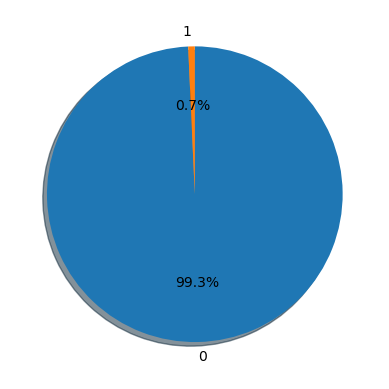

In [39]:
EDAVisualizer().pie_plot(data=hdf_res, column='SCORE',
                         legend=False, explode=0,
                         startangle=90, counterclock=False
                        );

🤓 **Let's discuss**:
* What we can say about this prediction